In [140]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
conf = (SparkConf()
            .setAppName('data_explore')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "5")
conf.set("spark.driver.memory", "3g")

In [66]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [67]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('escape', '"')
      .option('header', 'true')
      .load('hdfs://namenode:9000/data/process_logs.csv') 
     )

## Data Cleaning and feature engineering
+ parse process name/process path
+ split `Process_Command_Line` into tokens to count arguments
+ add boolean value to identify if process was started by an administrator
+ add boolean value to identify if path is in trusted directory: [C:\Program Files, C:\Windows]

In [88]:
from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date
clean_df = df.select(
    '*',
    regexp_extract(col('New_Process_Name'), r'(\w+.?\w+$)', 0).alias('process_name'),
    regexp_extract(col('New_Process_Name'), r"(\w?:?.*\\?\w+\s?\w+\\)", 0).alias('process_path'),
    regexp_replace(col('user'), r'\$', '').alias('user_name'),
    regexp_replace(col('Process_Command_Line'), r'(")', '').alias('command_line'),
    split(col('Process_Command_Line'), '\s+(?=[-/]+)').alias('cmd_line_split')
).selectExpr(
        'Account_Domain as domain', 'Creator_Process_ID as creator_process_id', 'EventCode as event_code', 'host', 'Logon_ID as logon_id', 'member_id', \
        'New_Process_ID as new_process_id', 'command_line', 'process_name', 'process_path', 'session_id', 'user_name', 'cmd_line_split', '_time as time'
).withColumn(
    'is_admin', col('member_id').isin(['FROTHLY\\administrator', 'NT AUTHORITY\\SYSTEM', 'NT AUTHORITY\\LOCAL SERVICE', 'NT AUTHORITY\\NETWORK SERVICE']).cast('int')
).withColumn(
    'trusted_path', (col('process_path').like('%C:\Program Files%') | col('process_path').like('%C:\Windows%') | col('process_path').like('%C:\PROGRA~2%') |col('process_path').like('%Program Files (x86)%')).cast('int')
).dropna(how='any')

clean_df.cache()

DataFrame[domain: string, creator_process_id: string, event_code: int, host: string, logon_id: string, member_id: string, new_process_id: string, command_line: string, process_name: string, process_path: string, session_id: string, user_name: string, cmd_line_split: array<string>, time: int, is_admin: int, trusted_path: int]

In [89]:
clean_df.groupBy('user_name','is_admin','process_name','trusted_path','process_path').count().show(truncate=False)

+-------------+--------+-------------------+------------+------------------------------------------------------------------------------------+-----+
|user_name    |is_admin|process_name       |trusted_path|process_path                                                                        |count|
+-------------+--------+-------------------+------------+------------------------------------------------------------------------------------+-----+
|WRK-ABUNGST  |1       |powershell.exe     |1           |C:\Program Files\SplunkUniversalForwarder\bin\                                      |14126|
|WRK-ABUNGST  |1       |MonitorNoHandle.exe|1           |C:\Program Files\SplunkUniversalForwarder\bin\                                      |8131 |
|WRK-FMALTES  |1       |netmon.exe         |1           |C:\Program Files\SplunkUniversalForwarder\bin\                                      |7649 |
|WRK-BTUN     |1       |MonitorNoHandle.exe|1           |C:\Program Files\SplunkUniversalForwarder\bin\   

## process count

In [90]:
from pyspark.sql.functions import count, desc, asc, expr
df_process_count = clean_df.groupBy('process_name').agg(
    count('process_name').alias('process_count')
)

In [91]:
df_process_count.orderBy(desc('process_count')).show(20, False)

+----------------------+-------------+
|process_name          |process_count|
+----------------------+-------------+
|powershell.exe        |124310       |
|winprintmon.exe       |74964        |
|MonitorNoHandle.exe   |70836        |
|netmon.exe            |68734        |
|winhostinfo.exe       |66849        |
|admon.exe             |55794        |
|conhost.exe           |39452        |
|cscript.exe           |27535        |
|dllhost.exe           |13691        |
|schtasks.exe          |9187         |
|chrome.exe            |8744         |
|cmd.exe               |7915         |
|wsmprovhost.exe       |4901         |
|SearchProtocolHost.exe|4862         |
|slui.exe              |4438         |
|SearchFilterHost.exe  |3091         |
|GoogleUpdate.exe      |2811         |
|WmiPrvSE.exe          |2582         |
|taskhost.exe          |2372         |
|OSPPSVC.EXE           |1722         |
+----------------------+-------------+
only showing top 20 rows



# create additional features
1. number of command line arguments
2. count of path 
3. if executable is common attack tool (i.e. at.exe, sc.exe, powershell.exe)
4. if executable ran from a trusted path

## number of command line arguments

In [92]:
from pyspark.sql.functions import split
df_arg_count = clean_df.groupBy('command_line', 'cmd_line_split').agg(
    (size('cmd_line_split')).alias('argument_count')
).select('command_line', 'argument_count')

In [122]:
df_arg_count.show(2, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|command_line                                                                                                                                              |argument_count|
+----------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|C:\Program Files\SplunkUniversalForwarder\bin\splunk-admon.exe                                                                                            |1             |
|schtasks.exe /Create /tn Microsoft\Office\Office Automatic Updates /XML C:\Program Files\Common Files\Microsoft Shared\ClickToRun\OfficeUpdateSchedule.xml|4             |
+-------------------------------------------------------------------------------------------------------------------------------------------

In [126]:
df_arg_count.filter(col('argument_count') > 2).show(5)

+--------------------+--------------+
|        command_line|argument_count|
+--------------------+--------------+
|schtasks.exe /Cre...|             4|
|schtasks.exe /Cre...|             4|
|C:\Windows\system...|             4|
|C:\Windows\system...|             3|
|C:\Program Files ...|             9|
+--------------------+--------------+
only showing top 5 rows



## count of path
+ count the number of times of the executable's path 

In [95]:
df_path_count = clean_df.select('process_path').groupBy('process_path').count().orderBy(desc('count'))

In [96]:
df_path_count.show(5, False)

+-------------------------------------------------+------+
|process_path                                     |count |
+-------------------------------------------------+------+
|C:\Program Files\SplunkUniversalForwarder\bin\   |456891|
|C:\Windows\System32\                             |110607|
|C:\Windows\SysWOW64\                             |17233 |
|C:\Program Files (x86)\Google\Chrome\Application\|8744  |
|C:\Windows\System32\WindowsPowerShell\           |4628  |
+-------------------------------------------------+------+
only showing top 5 rows



## if executable is common attack tool (i.e. at.exe, sc.exe, powershell.exe)
+ import splunk tools.csv and create tool array
+ check to see if the exectuble is a common attack tools such as [at.exe, sc.exe, powershell.exe]

In [97]:
tool_df = (spark.read.format('csv')
           .option('inferschema', 'true')
           .option('header', 'true')
           .load('hdfs://namenode:9000/data/tools.csv')
          )

In [98]:
# create list of tool names by taking the value of the filename key from every row object in tool_df
tool_list = [x['filename'] for x in tool_df.select('filename').collect()]

In [99]:
util_df = clean_df.groupBy('process_name').agg(
    clean_df['process_name'].isin(tool_list).cast('int').alias('common_attack_tool')
)

In [100]:
util_df.show()

+--------------------+------------------+
|        process_name|common_attack_tool|
+--------------------+------------------+
|          netmon.exe|                 0|
|           admon.exe|                 0|
|        taskhost.exe|                 0|
|SearchFilterHost.exe|                 0|
|             cmd.exe|                 0|
|          acregl.exe|                 0|
|         findstr.exe|                 0|
|GoogleCrashHandle...|                 0|
|           VSSVC.exe|                 0|
|        rundll32.exe|                 0|
|        aitagent.exe|                 0|
|        MpCmdRun.exe|                 0|
|            ngen.exe|                 0|
|              sc.exe|                 1|
|             reg.exe|                 0|
|        ceipdata.exe|                 0|
|             mmc.exe|                 0|
|        ie4uinit.exe|                 0|
|           csrss.exe|                 0|
|        iexplore.exe|                 0|
+--------------------+------------

## if executable ran from a trusted path

In [101]:
clean_df.groupBy('process_path', 'trusted_path').count().show(20, False)

+-------------------------------------------------------------------------------------------------+------------+-----+
|process_path                                                                                     |trusted_path|count|
+-------------------------------------------------------------------------------------------------+------------+-----+
|C:\Program Files (x86)\Google\Update\                                                            |1           |3201 |
|C:\Program Files\Common Files\Microsoft Shared\OfficeSoftwareProtectionPlatform\                 |1           |1722 |
|C:\Windows\Microsoft.NET\Framework64\v4.0.30319\                                                 |1           |6    |
|C:\Program Files (x86)\Symantec\Symantec Endpoint Protection\12.1.7266.6800.105\Bin64\           |1           |1    |
|C:\Program Files\VMware\VMware Tools\                                                            |1           |3    |
|C:\Users\al.bungstien\AppData\Local\Google\Chro

# combine data frames

In [177]:
df1 = clean_df.join(df_process_count, on='process_name').selectExpr(
    'user_name', 'process_name', 'process_count', 'command_line', 'process_path', 'is_admin', 'trusted_path'
)

In [178]:
df2 = df1.join(df_arg_count, on='command_line').selectExpr(
    'user_name', 'process_name', 'process_count', 'command_line', 'process_path', 'is_admin', 'trusted_path', 'argument_count'
)

In [179]:
df3 = df2.join(df_path_count, on='process_path').selectExpr(
    'user_name', 'process_name', 'process_count', 'command_line', 'process_path', 'is_admin', 'trusted_path', 'argument_count', 'count as path_count'
)

In [180]:
df3.filter((col('trusted_path') == 0) & (col('process_name') != 'software_reporter_tool.exe')).show(150)

+------------+------------+-------------+--------------------+--------------------+--------+------------+--------------+----------+
|   user_name|process_name|process_count|        command_line|        process_path|is_admin|trusted_path|argument_count|path_count|
+------------+------------+-------------+--------------------+--------------------+--------+------------+--------------+----------+
|amber.turing|     tor.exe|            1|C:\Users\amber.tu...|C:\Users\amber.tu...|       0|           0|             3|         1|
|          %2|            |            2|                  %9|                    |       0|           0|             1|         2|
|          %2|            |            2|                  %9|                    |       0|           0|             1|         2|
|    service3|  python.exe|            2|C:\python27\pytho...|        C:\Python27\|       0|           0|             1|         2|
|    service3|  python.exe|            2|c:\Python27\pytho...|        C:\Pyt

In [153]:
df3.select(F.stddev(col('process_count'))).show()

+--------------------------+
|stddev_samp(process_count)|
+--------------------------+
|         36265.44056743779|
+--------------------------+



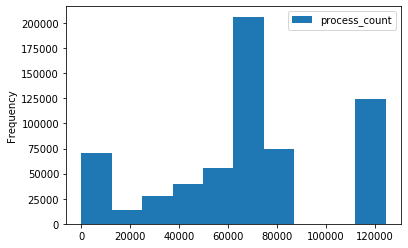

In [154]:
df3.select('process_count').toPandas().plot.hist()

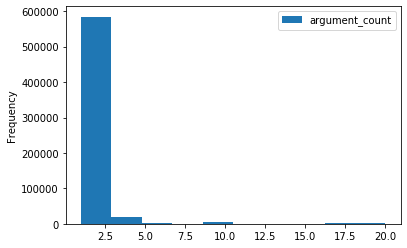

In [155]:
df3.select('argument_count').toPandas().plot.hist()

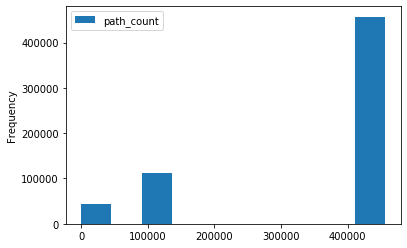

In [146]:
df3.select('path_count').toPandas().plot.hist()

In [185]:
df3.filter((col('argument_count') > 3) & (col('trusted_path')==0)).groupBy('user_name', 'process_name', 'process_path', 'trusted_path', 'process_count', 'path_count').count().show(truncate=False)

+------------+--------------------------+-----------------------------------------------------------------------+------------+-------------+----------+-----+
|user_name   |process_name              |process_path                                                           |trusted_path|process_count|path_count|count|
+------------+--------------------------+-----------------------------------------------------------------------+------------+-------------+----------+-----+
|amber.turing|software_reporter_tool.exe|C:\Users\amber.turing\AppData\Local\Google\Chrome\User Data\SwReporter\|0           |408          |2         |1    |
|al.bungstien|software_reporter_tool.exe|C:\Users\al.bungstien\AppData\Local\Google\Chrome\User Data\SwReporter\|0           |408          |2         |1    |
|service3    |python.exe                |C:\Python27\                                                           |0           |2            |2         |1    |
|amber.turing|firefox.exe               |C:\Users\am